<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/basic_level_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import time
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Cleaning the VRAM memory
#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats(device=None)
#print("Espacio disponible en GPU (Gb): ", torch.cuda.memory_allocated()*1e-9)

  # Accuracy = TP + TN / (TP + TN + FP + FN)
  # Precision = TP / (TP + FP)
  # Recall = TP / (TP + FN) 
  # F1 = 2 * (Precision * Recall) / (Precision + Recall)
  
#y_true = [[1, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0]]
#y_pred = [[1, 0, 0, 1], [0, 1, 0, 0], [0, 1, 1, 0]]
#precision_score(y_true, y_pred, average='weighted', zero_division=1)
#recall_score(y_true, y_pred, average='weighted', zero_division=1)
#f1_score(y_true, y_pred, average='weighted', zero_division=0)

In [2]:
#----------Paths----------

images_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Augmented_dataset/'
original_labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/original_labels.csv'
original_names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/original_names.csv'
augmented_labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/augmented_labels.csv'
augmented_names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/augmented_names.csv'
original_ds_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Original_dataset.h5'
augmented_ds_path =r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Augmented_dataset.h5'

original_names = pd.read_csv(original_names_path, header = None)
original_names = original_names.values.tolist()

labels_raw = pd.read_csv(original_labels_path, header = None)
labels_raw = labels_raw.values.tolist()
original_labels = []
for label in labels_raw:
  original_labels.append(label[0])

augmented_names = pd.read_csv(augmented_names_path, header = None)
augmented_names = augmented_names.values.tolist()

labels_raw = pd.read_csv(augmented_labels_path, header = None)
labels_raw = labels_raw.values.tolist()
augmented_labels = []
for label in labels_raw:
  augmented_labels.append(label[0])


Etiquetas divididas para cada muestra:  [['FewNuclearDots', 'FineSpeckled'], ['Negative'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['Negative'], ['Centromere'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['NuclearHomogeneous', 'MultipleNuclearDots'], ['Negative'], ['FineSpeckled', 'FewNuclearDots', 'NUMA-1MSA-1'], ['Negative'], ['Negative'], ['NuclearHomogeneous', 'NucleolarClumpy'], ['Negative'], ['FineSpeckled', 'NucleolarClumpy'], ['NUMA-1MSA-1'], ['Negative'], ['Negative'], ['Negative'], ['NuclearHomogeneous', 'NucleolarClumpy'], ['NucleolarClumpy'], ['NuclearMembranepores'], ['Negative'], ['NucleolarClumpy', 'FineSpeckled', 'CytoplasmicReticularAMA'], ['Negative'], ['FineSpeckled', 'CytoplasmicSpeckled'], ['NuclearHomogeneous', 'FewNuclearDots'], ['CoarseSpeckled', 'CytoplasmicSpeckled'], ['NUMA-1MSA-1'], ['Negative'], ['NuclearHomogeneous', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['CytoplasmicPolarGolgiLike'], ['NuclearHomogeneous', 'CytoplasmicReticularAMA'], [

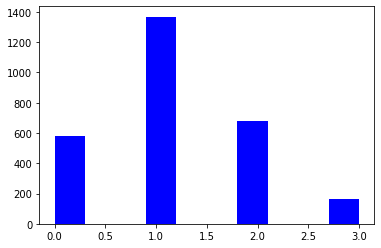


Etiquetas divididas para cada muestra:  [['FewNuclearDots', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Centromere'], ['Centromere'], ['Centromere'], ['Centromere'], ['Centromere'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['NuclearHomogeneous', 'MultipleNuclearDots'], ['NuclearHomogeneous', 'MultipleNuclearDots'], ['NuclearHomogeneous', 'Multi

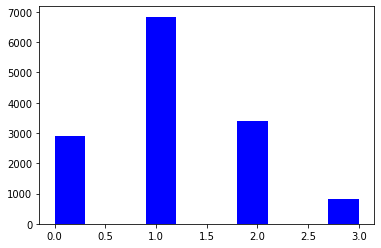

In [3]:
#----------Etiquetado de cada imagen----------

def Labeling(label_list):

  split_labels = []
  basic_level_labels_raw = []
  basic_level_labels = []
  basic_level_labels_to_model = []

  for label in label_list: # Separamos las etiquetas para cada muestra
    split_labels.append(label.split("_"))

  for label in split_labels:
    group = []
    for basic_label in label:
      if (basic_label == "NuclearHomogeneous" or basic_label == "DSF-70" or basic_label == "Centromere" or 
          basic_label == "FineSpeckled" or basic_label == "CoarseSpeckled" or basic_label == "MultipleNuclearDots" or
          basic_label == "FewNuclearDots" or basic_label == "NucleolarHomogeneous" or basic_label == "NucleolarClumpy" or
          basic_label == "NucleolarSpeckled" or basic_label == "NuclearMembranous" or basic_label == "NuclearMembranepores" or
          basic_label == "PCNA" or basic_label == "PCNA(ProliferatingCellNuclearAntigen)" or basic_label == "SCl-70"):  # Hay algunas imagenes con la etiqueta PCNA(ProliferatingCellNuclearAntigen)
        group.append(1)
      elif (basic_label == "CytoplasmicSpeckled" or basic_label == "CytolplasmicSpeckled" or basic_label == "CytoplasmicFibrillar" or # Hay algunas imagenes con la etiqueta CytolplasmicSpeckled
            basic_label == "CytoplasmicReticularAMA" or basic_label == "CytoplasmicPolarGolgiLike" or basic_label == "Tubulin"):
        group.append(2)
      elif (basic_label == "Centriole" or basic_label == "NUMA-1MSA-1" or basic_label == "Midbody(MSA-2)"):
        group.append(3)
      elif (basic_label == "Negative"):
        group.append(0)
      else:
        print("LOS QUE FALTAN: ", basic_label)
    
    basic_level_labels_raw.append(group)

  for group in basic_level_labels_raw:
    basic_level_labels.append(list(set(group)))

  for group in basic_level_labels:
    total_label_group = [0, 0, 0, 0]
    for clase in group:
      total_label_group[clase] = 1
    basic_level_labels_to_model.append(total_label_group)

  print("\nEtiquetas divididas para cada muestra: ", split_labels)
  print("Etiquetas traducidas a los 4 grandes grupos: ", basic_level_labels_raw)
  print("Etiquetas traducidas a los 4 grandes grupos (sin valores repetidos): ", basic_level_labels)
  print("\nEtiquetas finales para el modelo: ", basic_level_labels_to_model)
  print("Tamano de arreglo de etiquetas finales: ", len(basic_level_labels_to_model))

  return basic_level_labels_to_model

#----------Pesos e histograma de labels----------

def Weights_and_Histogram(basic_level_labels):

  Negatives = 0
  Nuclear = 0
  Cytoplasmic = 0
  Mitotic = 0
  weights, histogram_data = [], []

  for labels in basic_level_labels:  
    if labels[0] == 1:
      Negatives += 1
      histogram_data.append(0)
    if labels[1] == 1:
      Nuclear += 1
      histogram_data.append(1)
    if labels[2] == 1:
      Cytoplasmic += 1
      histogram_data.append(2)
    if labels[3] == 1:
      Mitotic += 1
      histogram_data.append(3)

  # Creacion de un vector de pesos para balancear las clases
  weights.append(Negatives)
  weights.append(Nuclear)
  weights.append(Cytoplasmic)
  weights.append(Mitotic)
  weights = np.array(weights)
  weights = 1/weights
  weights = weights/np.sum(weights)
  weights = torch.tensor(weights, dtype=torch.float)
  print(weights.type())

  print("Negativos: ", Negatives, "\nNuclear: ", Nuclear,
        "\nCitoplasmaticos: ", Cytoplasmic, "\nMitotico: ", Mitotic)
  print("Pesos de cada clase: ", weights)
  plt.hist(histogram_data, facecolor = 'blue', alpha = 1)
  plt.show()

  return weights

original_labels = Labeling(original_labels)
original_weights = Weights_and_Histogram(original_labels)

augmented_labels = Labeling(augmented_labels)
augmented_weights = Weights_and_Histogram(augmented_labels)


In [4]:
#----------Creacion de datasets----------
augmented_data = True

if(augmented_data):
  labels = augmented_labels
  names = augmented_names
  dataset = h5py.File(augmented_ds_path, 'r') 
else:
  labels = original_labels
  names = original_names
  dataset = h5py.File(original_ds_path, 'r')

x_train, x_val_test, y_train, y_val_test = train_test_split(names, labels, test_size = 0.3, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 42)

tensor([0, 1, 1, 0])


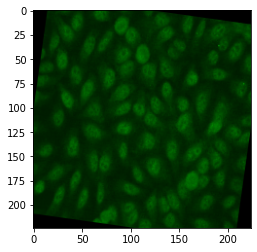

tensor([0, 1, 0, 0])


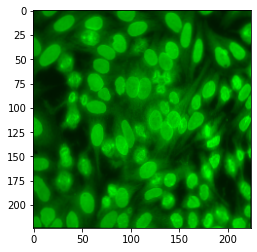

tensor([0, 1, 0, 0])


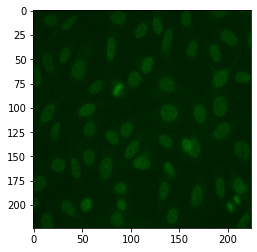

In [5]:
#----------Clase Dataset Personaliazdo----------

class CustomImageDataset(Dataset):
    def __init__(self, dataset, names, labels, transform=None):
        self.dataset = dataset
        self.names = names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.names[idx][0].split('.')[0]
        image = self.dataset.get(image_name)[:] 
        image = torch.tensor(image)  
        label = torch.tensor(self.labels[idx])    

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Creando Dataloader para los conjuntos de entrenamiento y prueba

Batch_size = 64

train_data = CustomImageDataset(dataset, x_train, y_train) # transform=Custom_transform
train_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=False, num_workers=2)   #-------------------------Cambiar el shuffle-----------------------

val_data = CustomImageDataset(dataset, x_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=Batch_size, shuffle=False, num_workers=2)       #-------------------------Cambiar el shuffle----------------------- 

test_data = CustomImageDataset(dataset, x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=Batch_size, shuffle=False, num_workers=2)    #-------------------------Cambiar el shuffle-----------------------

images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])
#print(names[0])
plt.show()

images, labels = next(iter(val_dataloader))
plt.imshow(images[0])
print(labels[0])
#print(names[0])
plt.show()

images, labels = next(iter(test_dataloader))
plt.imshow(images[0])
print(labels[0])
#print(names[0])
plt.show()

In [6]:
# Clase para adaptar modelo pre-entrenados

class MyExtendedNet(nn.Module):
    def __init__(self, pretrained_model):
        super(MyExtendedNet, self).__init__()
        self.pretrained = pretrained_model
        self.new_layer = nn.Sequential(nn.Linear(1000, 1000),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(1000, 500),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(500, 100),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(100, 10),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(10, 4), # nn.Linear(10, 1), para BCELoss
                                         #nn.Sigmoid()      # Para BCELoss
                                         )     
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.pretrained(x)
        x = self.new_layer(x)
        return x

In [7]:
def train_model_2(model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, device):

    model.to(device)
    training_loss, validation_loss = [], []
    aux_loss = 0.1
    aux_acc = 0.9
    average = 'weighted'

    for epoch in range(0, epochs):
        model.train()
        train_loss, train_acc, train_prec, train_recall, train_f1 = [], [], [], [], []
        for batch in iter(train_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            optimizer.zero_grad()
            Y_hat = model(X)
            loss = loss_fn(Y_hat, Y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
            Y_hat[Y_hat > 0.5] = 1
            Y_hat[Y_hat < 1] = 0
            
            # Metricas
            # GPU
            if (device == torch.device('cuda:0')):
              acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
              prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
              recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
              f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0) 
            # CPU
            else:
              acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
              prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
              recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
              f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
            
            train_acc.append(acc)
            train_prec.append(prec) 
            train_recall.append(recall)
            train_f1.append(f1)
        
        model.eval()
        val_loss, val_acc, val_prec, val_recall, val_f1 = [], [], [], [], []
        with torch.no_grad():
            for batch in iter(val_dataloader):
                X, Y = batch
                X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
                Y_hat = model(X)
                loss = loss_fn(Y_hat, Y)
                val_loss.append(loss.item())
                
                Y_hat[Y_hat > 0.5] = 1
                Y_hat[Y_hat < 1] = 0

                # Metricas
                # GPU
                if (device == torch.device('cuda:0')):
                  acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
                  prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
                  recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
                  f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0) 
                # CPU
                else:
                  acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
                  prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
                  recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
                  f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
                
                val_acc.append(acc)
                val_prec.append(prec) 
                val_recall.append(recall)
                val_f1.append(f1)
        
        print(f"Epoca:{epoch + 1}/{epochs} \n")
        print(f"train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f} \n")
        print(f"train acc: {np.mean(train_acc):.5f}, val acc: {np.mean(val_acc):.5f} \n")
        print(f"train prec: {np.mean(train_prec):.5f}, val prec: {np.mean(val_prec):.5f} \n")
        print(f"train recall: {np.mean(train_recall):.5f}, val recall: {np.mean(val_recall):.5f} \n")
        print(f"train f1: {np.mean(train_f1):.5f}, val f1: {np.mean(val_f1):.5f} \n")

        if(np.mean(val_loss) < aux_loss):
          aux_loss = np.mean(val_loss)
          print("Menor perdida en validacion  = ", aux_loss, " en la epoca: ", epoch, "\n")

        if(np.mean(val_acc) > aux_acc):
          torch.save(model.state_dict(), 'drive/MyDrive/Colab_Notebooks/Tesis/Models/Binary_model.pt')
          aux_acc = np.mean(val_acc)
          print("Modelo guardado con Accuracy = ", aux_acc, "\n")

        training_loss.append(np.mean(train_loss))
        validation_loss.append(np.mean(val_loss))
         
    return training_loss, validation_loss

In [8]:
def test_model_2(model, test_loader, device):
    
    #model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/Basic_level_model.pt', map_location=device))
    #print("Modelo cargado.\n")
    
    model.to(device)
    average = 'weighted'
    model.eval()
    test_loss, test_acc, test_prec, test_recall, test_f1 = [], [], [], [], []
    with torch.no_grad():
        for batch in iter(test_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            Y_hat = model(X)

            Y_hat[Y_hat > 0.5] = 1
            Y_hat[Y_hat < 1] = 0

            # Metricas
            # GPU
            if (device == torch.device('cuda:0')):
              acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
              prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
              recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
              f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0) 
            # CPU
            else:
              acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
              prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
              recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
              f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
            
            test_acc.append(acc)
            test_prec.append(prec) 
            test_recall.append(recall)
            test_f1.append(f1)
    
    return (np.mean(test_acc), np.mean(test_prec), np.mean(test_recall), np.mean(test_f1))

In [9]:
# Creacion del modelo

!pip install timm
import torchvision.models as models
import timm

# Creacion del modelo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model = models.alexnet(pretrained=True)
model = models.densenet201(pretrained=True)
#model = timm.create_model('inception_resnet_v2', pretrained=True)
basic_level_model = MyExtendedNet(model)

weights = original_weights

#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss(weight = weights)
optimizer = torch.optim.Adam(basic_level_model.parameters(), lr = 0.001)
epochs = 100
if torch.cuda.is_available():
    basic_level_model.cuda()
    weights = torch.tensor(weights, device=device)
    loss_fn.cuda()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 32.3 MB/s 


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoca:1/100 

train loss: 0.22620, val loss: 0.17616 

train acc: 0.22244, val acc: 0.30467 

train prec: 0.64102, val prec: 0.78084 

train recall: 0.32154, val recall: 0.59529 

train f1: 0.38520, val f1: 0.65786 

Epoca:2/100 

train loss: 0.20766, val loss: 0.19597 

train acc: 0.25238, val acc: 0.18057 

train prec: 0.74151, val prec: 0.75045 

train recall: 0.45629, val recall: 0.64166 

train f1: 0.53880, val f1: 0.65805 

Epoca:3/100 

train loss: 0.19822, val loss: 0.19515 

train acc: 0.23410, val acc: 0.26293 

train prec: 0.76717, val prec: 0.74371 

train recall: 0.51491, val recall: 0.71179 

train f1: 0.58696, val f1: 0.70061 

Epoca:4/100 

train loss: 0.19231, val loss: 0.16450 

train acc: 0.25239, val acc: 0.28946 

train prec: 0.76765, val prec: 0.77971 

train recall: 0.52336, val recall: 0.64666 

train f1: 0.58898, val f1: 0.66683 

Epoca:5/100 

train loss: 0.18346, val loss: 0.19351 

train acc: 0.25731, val acc: 0.31280 

train prec: 0.77641, val prec: 0.76508

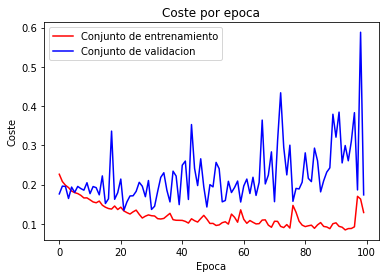

In [10]:
# Entrenamiento y validacion

start_time = time.time()
training_cost, validation_cost = train_model_2(
    basic_level_model,
    optimizer,
    loss_fn, 
    train_dataloader, 
    val_dataloader,  
    epochs,
    device)
final_time = time.time() - start_time

#print("Estructura del modelo: \n", basic_level_model, "\n")
print('Tiempo de entrenamiento:', round(final_time/60, 3), " min \n")
plt.plot(range(epochs), training_cost, color = "r", label = "Conjunto de entrenamiento")
plt.plot(range(epochs), validation_cost, color = "b", label = "Conjunto de validacion")
plt.title("Coste por epoca")
plt.xlabel("Epoca")
plt.ylabel("Coste")
plt.legend()
plt.show()

In [14]:
# Prueba del modelo

start_time = time.time()
test_acc, test_pre, test_recall, test_F1 = test_model_2(
    basic_level_model, 
    test_dataloader, 
    device)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_pre, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2))

Tiempo de test: 0.187 

Metricas del test:
 Exactitud:  0.49  Precision:  0.74  Recall:  0.89  F1:  0.79
